## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

Running 12760 CDFs


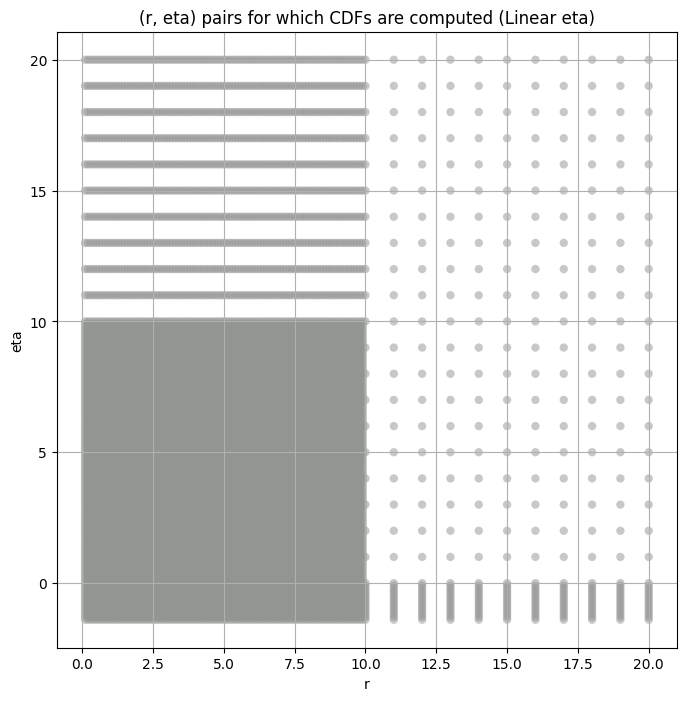

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:56<00:00, 1778.68it/s]


Layer 3


100%|██████████| 100000/100000 [00:50<00:00, 1972.17it/s]


Layer 4


100%|██████████| 100000/100000 [00:41<00:00, 2413.78it/s]


Layer 5


100%|██████████| 100000/100000 [00:41<00:00, 2394.24it/s]


Layer 6


100%|██████████| 100000/100000 [00:41<00:00, 2410.84it/s]


Layer 7


100%|██████████| 100000/100000 [00:41<00:00, 2427.44it/s]


Layer 8


100%|██████████| 100000/100000 [00:41<00:00, 2428.39it/s]


Layer 9


100%|██████████| 100000/100000 [00:41<00:00, 2428.43it/s]


obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      17099.889000  16011.852000  18265.586000    4.485044    2.916572   
3       4439.300000   4054.772500   4889.472000   11.245152    5.995430   
4       1375.080000   1259.382700   1507.248500    9.946786    6.166633   
5        383.260470    347.355300    432.730400   15.705746    6.790785   
6         87.511570     79.346710     97.936560   14.393824    7.234257   
7         18.372211     16.360151     21.660490   26.509922    9.413936   
8          3.833243      3.316128      4.835760   50.959682   13.018395   
9          0.722330      0.589106      1.182013  243.188050   15.044268   

       kurt_upper  total_samples  
layer                             
2        6.961125        27208.0  
3       23.181372       108832.0  
4       20.850872       333298.0  
5       61.446915      1149538.0  
6       41.990230      4251250.0  
7      122.685720     17005000.0  
8      233.187880     68020000.0  
9      913.023500    272080000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      17099.889000   17099.888672    16030.998047    15467.041016   
3       4439.300000    4439.299805     4233.739746     4140.744629   
4       1375.080000    1375.079956     1318.386841     1287.494263   
5        383.260470     383.260468      363.920441      354.909149   
6         87.511570      87.511574       83.097481       80.926743   
7         18.372211      18.372211       17.207518       16.685528   
8          3.833243       3.833243        3.504497        3.370710   
9          0.722330       0.722330        0.621273        0.593887   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        15026.853516     14642.915039     13979.728516     13403.748047   
3         4064.408691      4000.471924      3889.999512      3793.819824   
4         1263.276001      1242.280029      1206.400879      1175.982666   
5          347.653625       341.437439       331.055573       322.332489   
6           79.220879        77.755852        75.283897        73.198723   
7           16.273451        15.923075        15.333748        14.839082   
8            3.267357         3.180761         3.037475         2.919355   
9            0.573435         0.556633         0.529379         0.507318   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         12901.083984     12449.439453     12033.960938     10956.639648  
3          3707.568604      3629.473389      3558.281494      3370.037109  
4          1149.090820      1124.812988      1102.426880      1043.939087  
5           314.621796       307.620911       301.190643       284.353851  
6            71.364761        69.713387        68.203201        64.275497  
7            14.406709        14.019439        13.667124        12.760725  
8             2.817600         2.727667         2.646774         2.442283  
9             0.488581         0.472182         0.457541         0.420958

####
Layer  2


100%|██████████| 12760/12760 [00:12<00:00, 1061.75it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.014667383684594304 17099.889


100%|██████████| 12760/12760 [00:11<00:00, 1075.59it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.014701577243897535 16030.998


100%|██████████| 12760/12760 [00:11<00:00, 1077.07it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.014752474995028686 15467.041


100%|██████████| 12760/12760 [00:11<00:00, 1078.17it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.015459889628705703 15026.854


100%|██████████| 12760/12760 [00:11<00:00, 1085.46it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.01705965398575382 14642.915


100%|██████████| 12760/12760 [00:11<00:00, 1083.39it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.01916130617265277 13979.729


100%|██████████| 12760/12760 [00:11<00:00, 1087.75it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.019432777766518583 13403.748


100%|██████████| 12760/12760 [00:11<00:00, 1086.26it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.01961955447592345 12901.084


100%|██████████| 12760/12760 [00:11<00:00, 1087.14it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.019926422347858685 12449.439


100%|██████████| 12760/12760 [00:11<00:00, 1086.82it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.022239814818127646 12033.961


100%|██████████| 12760/12760 [00:11<00:00, 1084.42it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.02683414946642293 10956.64
Number of samples: 27208, Without approximation : 27208.0


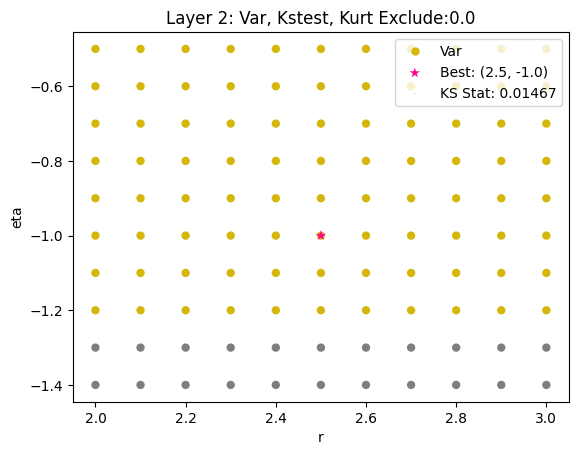

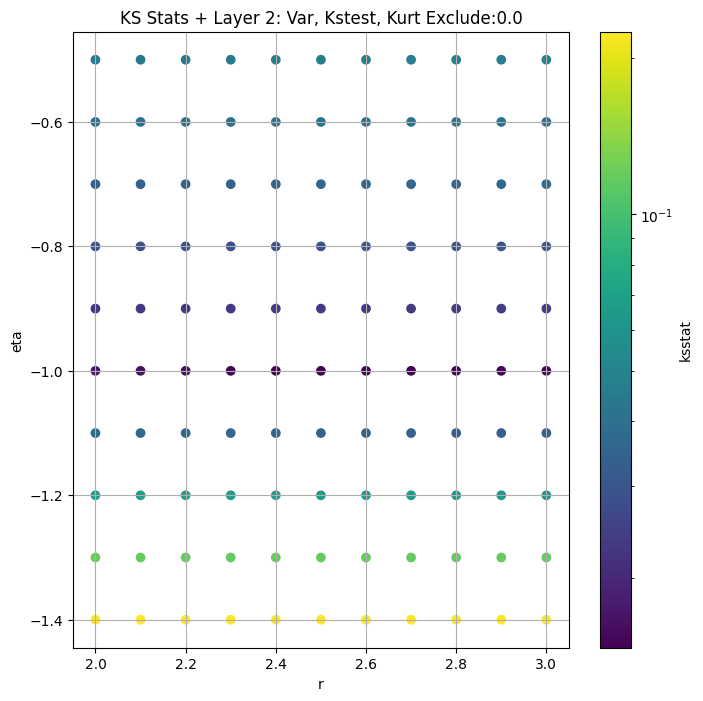

####
Layer  3


100%|██████████| 12760/12760 [00:42<00:00, 302.40it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.13191999999999976 4439.3


100%|██████████| 12760/12760 [00:42<00:00, 303.61it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.13191999999999976 4233.7397


100%|██████████| 12760/12760 [00:42<00:00, 300.81it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.13191999999999976 4140.7446


100%|██████████| 12760/12760 [00:43<00:00, 293.18it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.13191999999999976 4064.4087


100%|██████████| 12760/12760 [00:43<00:00, 296.20it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.13191999999999976 4000.472


100%|██████████| 12760/12760 [00:43<00:00, 294.81it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.13191999999999976 3889.9995


100%|██████████| 12760/12760 [00:43<00:00, 295.99it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.13191999999999976 3793.8198


100%|██████████| 12760/12760 [00:43<00:00, 294.90it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.13191999999999976 3707.5686


100%|██████████| 12760/12760 [00:43<00:00, 295.93it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.13191999999999976 3629.4734


100%|██████████| 12760/12760 [00:43<00:00, 296.73it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.13191999999999976 3558.2815


100%|██████████| 12760/12760 [00:43<00:00, 296.43it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.13191999999999976 3370.037
Number of samples: 100000, Without approximation : 108832.0


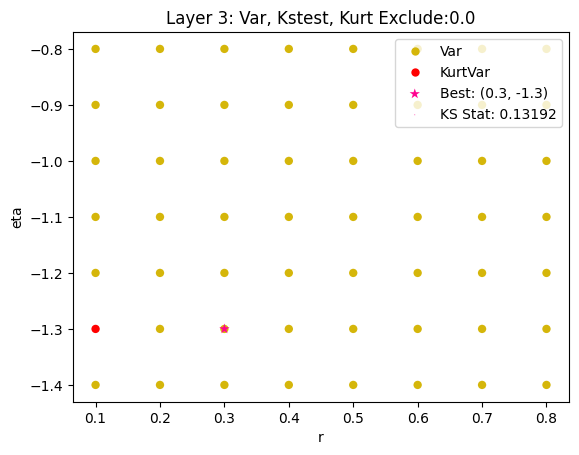

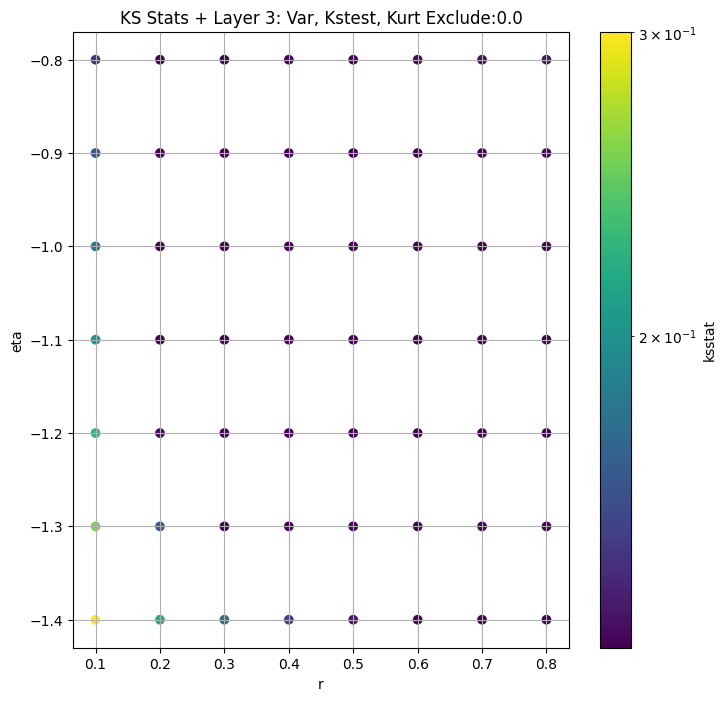

####
Layer  4


100%|██████████| 12760/12760 [00:42<00:00, 296.87it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.07504999999999984 1375.08


100%|██████████| 12760/12760 [00:43<00:00, 296.01it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.07504999999999984 1318.3868


100%|██████████| 12760/12760 [00:43<00:00, 296.52it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.07504999999999984 1287.4943


100%|██████████| 12760/12760 [00:44<00:00, 287.31it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.07504999999999984 1263.276


100%|██████████| 12760/12760 [00:44<00:00, 287.03it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.07504999999999984 1242.28


100%|██████████| 12760/12760 [00:44<00:00, 289.31it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.07504999999999984 1206.4009


100%|██████████| 12760/12760 [00:43<00:00, 296.32it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.07504999999999984 1175.9827


100%|██████████| 12760/12760 [00:42<00:00, 300.20it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.07504999999999984 1149.0908


100%|██████████| 12760/12760 [00:42<00:00, 300.74it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.07504999999999984 1124.813


100%|██████████| 12760/12760 [00:42<00:00, 301.94it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.07504999999999984 1102.4269


100%|██████████| 12760/12760 [00:42<00:00, 301.99it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.07504999999999984 1043.9391
Number of samples: 100000, Without approximation : 333298.0


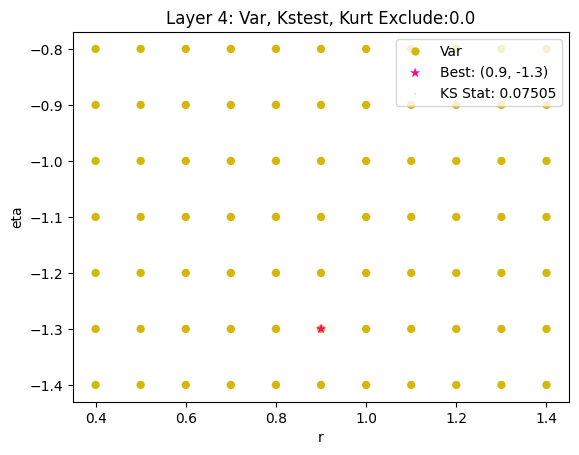

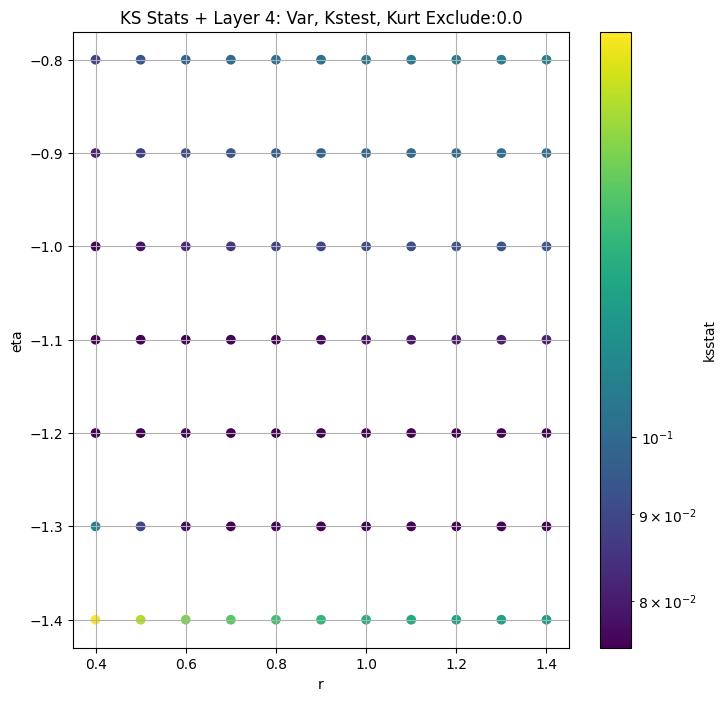

####
Layer  5


100%|██████████| 12760/12760 [00:42<00:00, 303.23it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.03975615000282762 383.26047


100%|██████████| 12760/12760 [00:42<00:00, 302.71it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.039755444780462335 363.92044


100%|██████████| 12760/12760 [00:42<00:00, 303.26it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.03975587127418473 354.90915


100%|██████████| 12760/12760 [00:42<00:00, 302.96it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.03975541317606379 347.65363


100%|██████████| 12760/12760 [00:42<00:00, 302.93it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.03975525726148482 341.43744


100%|██████████| 12760/12760 [00:42<00:00, 300.27it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.039755293729441143 331.05557


100%|██████████| 12760/12760 [00:42<00:00, 303.41it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.039755154960907924 322.3325


100%|██████████| 12760/12760 [00:42<00:00, 300.86it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.039754977379070244 314.6218


100%|██████████| 12760/12760 [00:42<00:00, 303.10it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.03975486047831733 307.6209


100%|██████████| 12760/12760 [00:42<00:00, 301.46it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.039754664162670095 301.19064


100%|██████████| 12760/12760 [00:42<00:00, 302.82it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.03983510064931989 284.35385
Number of samples: 100000, Without approximation : 1149538.0


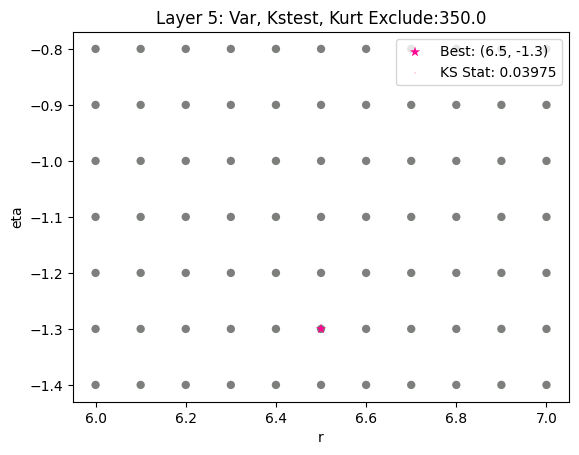

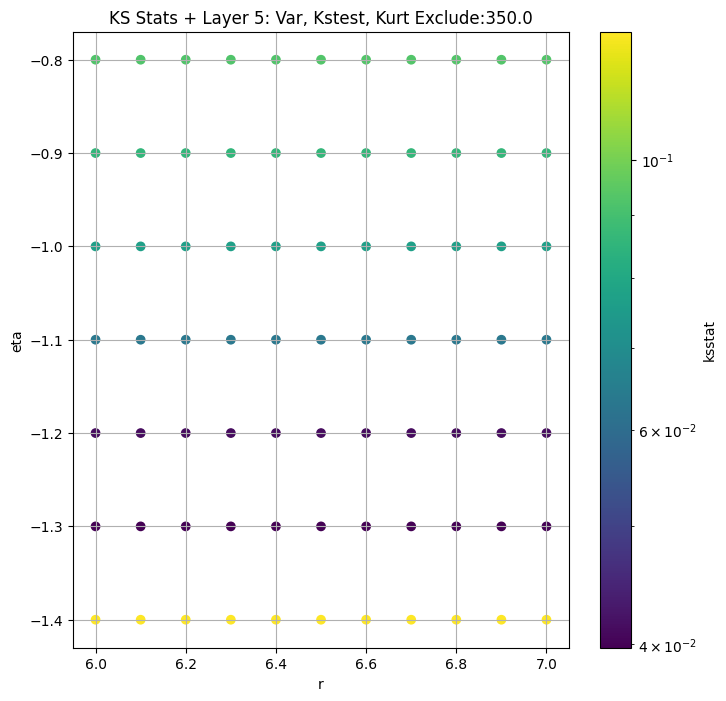

####
Layer  6


100%|██████████| 12760/12760 [00:42<00:00, 299.51it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.014040369243347839 87.51157


100%|██████████| 12760/12760 [00:42<00:00, 302.43it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.014081676286640255 83.09748


100%|██████████| 12760/12760 [00:44<00:00, 289.69it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.013587993130287579 80.92674


100%|██████████| 12760/12760 [00:42<00:00, 300.10it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.01402088063364404 79.22088


100%|██████████| 12760/12760 [00:42<00:00, 302.57it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.013672581183411747 77.75585


100%|██████████| 12760/12760 [00:42<00:00, 298.60it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.013762959130042884 75.2839


100%|██████████| 12760/12760 [00:42<00:00, 303.45it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.013823723408546651 73.19872


100%|██████████| 12760/12760 [00:42<00:00, 298.85it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.013930353274393903 71.36476


100%|██████████| 12760/12760 [00:42<00:00, 302.70it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.01415941973812368 69.71339


100%|██████████| 12760/12760 [00:42<00:00, 299.65it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.014124454964521416 68.2032


100%|██████████| 12760/12760 [00:42<00:00, 303.22it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.01414666885304372 64.2755
Number of samples: 100000, Without approximation : 4251250.0


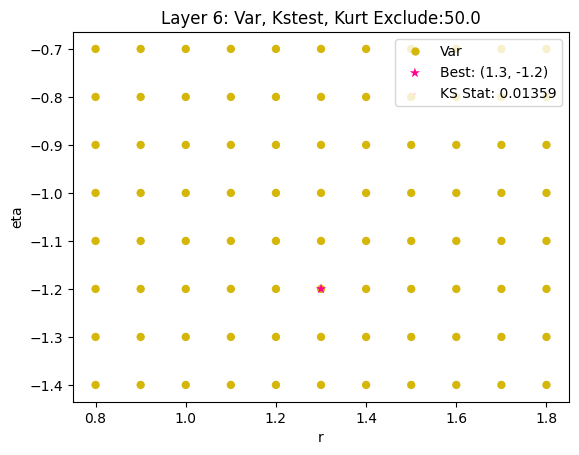

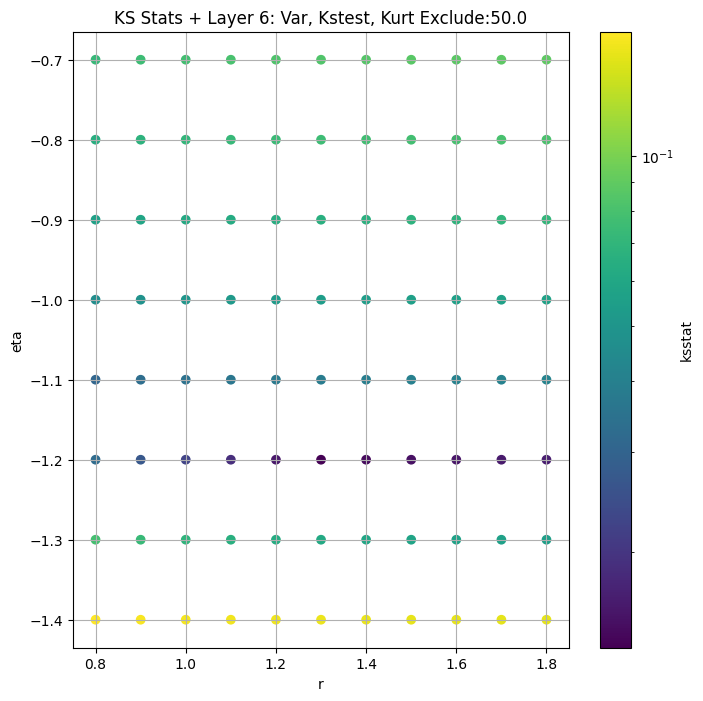

####
Layer  7


100%|██████████| 12760/12760 [00:42<00:00, 298.97it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.013380228438550523 18.372211


100%|██████████| 12760/12760 [00:42<00:00, 299.89it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.01342405083531284 17.207518


100%|██████████| 12760/12760 [00:42<00:00, 300.55it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.013491294942414134 16.685528


100%|██████████| 12760/12760 [00:43<00:00, 290.56it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.013657378656900754 16.27345


100%|██████████| 12760/12760 [00:42<00:00, 298.82it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.013279006367127977 15.923075


100%|██████████| 12760/12760 [00:42<00:00, 301.57it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.013464643015409172 15.333748


100%|██████████| 12760/12760 [00:43<00:00, 293.18it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.013435409432219214 14.839082


100%|██████████| 12760/12760 [00:42<00:00, 298.31it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.013247818989325755 14.406709


100%|██████████| 12760/12760 [00:43<00:00, 295.95it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.013221676775465041 14.019439


100%|██████████| 12760/12760 [00:42<00:00, 303.41it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.01332518667278515 13.667124


100%|██████████| 12760/12760 [00:42<00:00, 302.97it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.013302926034481466 12.760725
Number of samples: 100000, Without approximation : 17005000.0


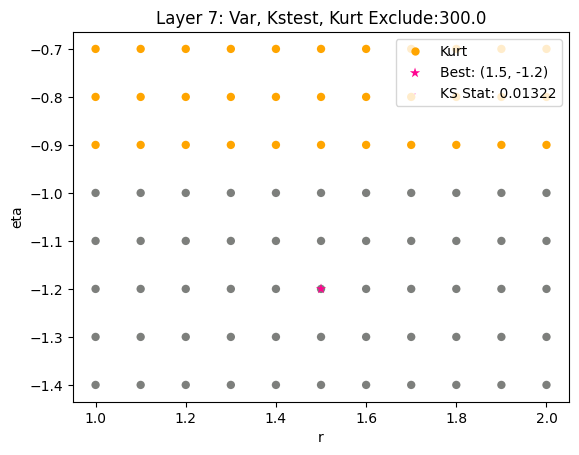

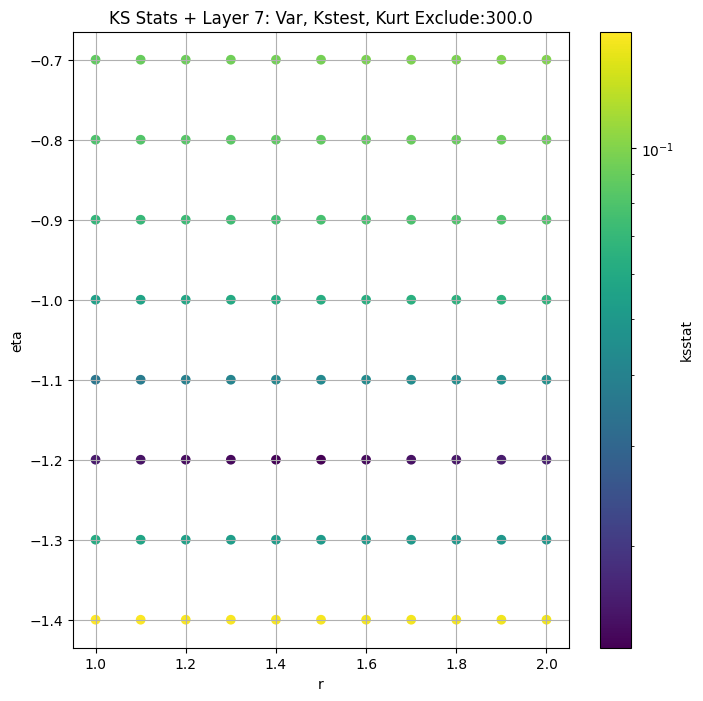

####
Layer  8


100%|██████████| 12760/12760 [00:42<00:00, 303.09it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.011955435117860125 3.8332431


100%|██████████| 12760/12760 [00:45<00:00, 281.74it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.012257593284814933 3.5044966


100%|██████████| 12760/12760 [00:42<00:00, 300.47it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.013498920542653892 3.3707104


100%|██████████| 12760/12760 [00:44<00:00, 288.39it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.011954078064527085 3.2673573


100%|██████████| 12760/12760 [00:46<00:00, 277.14it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.012173730104489244 3.1807609


100%|██████████| 12760/12760 [00:46<00:00, 275.30it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.012840307727446598 3.0374746


100%|██████████| 12760/12760 [00:43<00:00, 293.46it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.01354002584695796 2.919355


100%|██████████| 12760/12760 [00:42<00:00, 298.95it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.015183178303396452 2.8175998


100%|██████████| 12760/12760 [00:42<00:00, 301.37it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.016685505830094427 2.7276673


100%|██████████| 12760/12760 [00:42<00:00, 302.63it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.017124249223397447 2.6467736


100%|██████████| 12760/12760 [00:42<00:00, 303.01it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.015413203184783675 2.4422834
Number of samples: 100000, Without approximation : 68020000.0


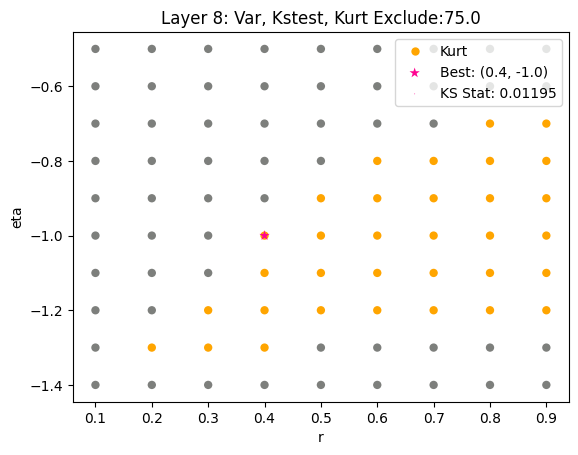

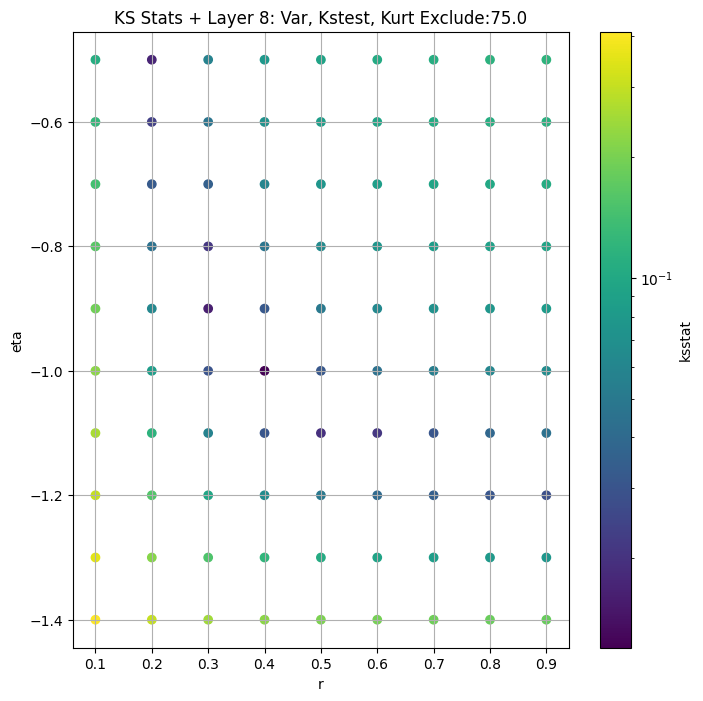

####
Layer  9


100%|██████████| 12760/12760 [00:42<00:00, 302.87it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.02345638374256842 0.72233033


100%|██████████| 12760/12760 [00:42<00:00, 301.47it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.023456100706710226 0.62127334


100%|██████████| 12760/12760 [00:43<00:00, 290.07it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.02345713003122374 0.5938866


100%|██████████| 12760/12760 [00:45<00:00, 281.73it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.023455544453134358 0.5734353


100%|██████████| 12760/12760 [00:43<00:00, 295.79it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.02345547770516776 0.5566327


100%|██████████| 12760/12760 [00:42<00:00, 299.47it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.023455362756314435 0.5293789


100%|██████████| 12760/12760 [00:42<00:00, 302.31it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.023455812190021685 0.5073182


100%|██████████| 12760/12760 [00:42<00:00, 303.13it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.02345573264167622 0.48858052


100%|██████████| 12760/12760 [00:42<00:00, 302.75it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.02345565917129455 0.47218162


100%|██████████| 12760/12760 [00:42<00:00, 299.21it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.023455470131787615 0.45754147


100%|██████████| 12760/12760 [00:42<00:00, 300.75it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.023455277399314745 0.42095834
Number of samples: 100000, Without approximation : 272080000.0


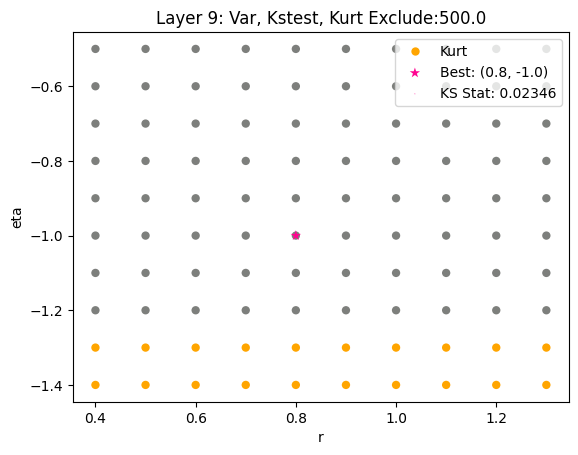

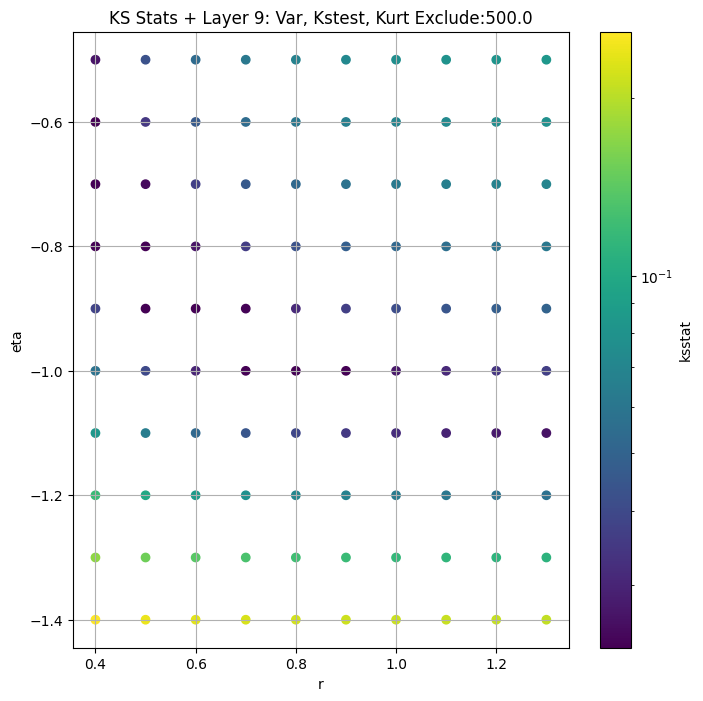

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      17099.889000  16011.852000  18265.586000    4.485044    2.916572   
3       4439.300000   4054.772500   4889.472000   11.245152    5.995430   
4       1375.080000   1259.382700   1507.248500    9.946786    6.166633   
5        383.260470    347.355300    432.730400   15.705746    6.790785   
6         87.511570     79.346710     97.936560   14.393824    7.234257   
7         18.372211     16.360151     21.660490   26.509922    9.413936   
8          3.833243      3.316128      4.835760   50.959682   13.018395   
9          0.722330      0.589106      1.182013  243.188050   15.044268   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        6.961125        27208.0             0.014667        2.5         -1.0   
3       23.181372       108832.0             0.131920        0.3         -1.3   
4       20.850872       333298.0             0.075050        0.9         -1.3   
5       61.446915      1149538.0             0.039755        6.5         -1.3   
6       41.990230      4251250.0             0.013588        1.3         -1.2   
7      122.685720     17005000.0             0.013222        1.5         -1.2   
8      233.187880     68020000.0             0.011954        0.4         -1.0   
9      913.023500    272080000.0             0.023455        0.8         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       52715.098704                     0.0        17099.889000   
3        1001.889251                     0.0         4439.300000   
4        6323.633607                     0.0         1375.080000   
5        1926.164660                   350.0          301.190640   
6         319.324128                    50.0           80.926740   
7          58.667144                   300.0           14.019439   
8           0.669579                    75.0            3.267357   
9           0.633358                   500.0            0.420958   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.008227  
3                     0.004115  
4                     0.002352  
5                     0.001267  
6                     0.000659  
7                     0.000329  
8                     0.000165  
9                     0.000082

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 81/81 [00:00<00:00, 1030.13it/s]


Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.020049192103827496, var: 14642.9150390625


100%|██████████| 81/81 [00:00<00:00, 1037.32it/s]


Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.02048422067298611, var: 15026.853515625


100%|██████████| 81/81 [00:00<00:00, 1036.88it/s]


Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.01887330846732338, var: 15467.041015625


100%|██████████| 81/81 [00:00<00:00, 1029.43it/s]


Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.016660393517264005, var: 16030.998046875


100%|██████████| 81/81 [00:00<00:00, 1029.31it/s]


Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.014667383684594304, var: 17099.888671875
Number of samples: 27208, Without approximation : 27208.0


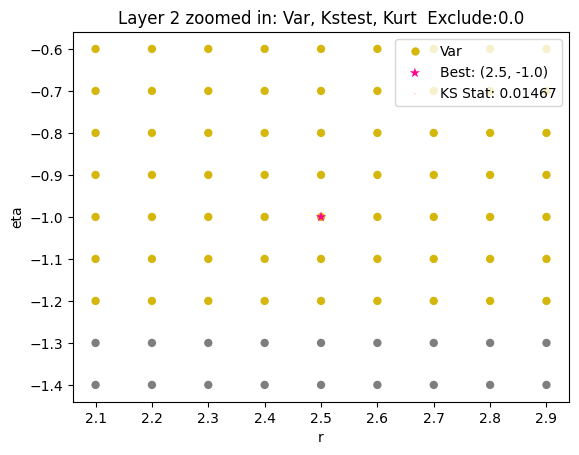

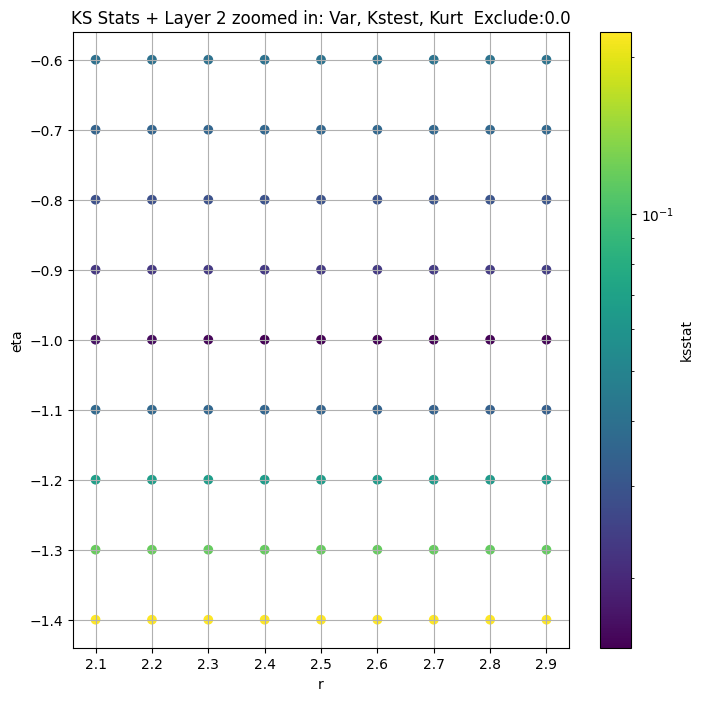

Layer 3


100%|██████████| 881/881 [00:02<00:00, 297.37it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.13191999999999976, var: 4000.471923828125


100%|██████████| 881/881 [00:02<00:00, 300.92it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.13191999999999976, var: 4064.40869140625


100%|██████████| 881/881 [00:02<00:00, 300.86it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.13191999999999976, var: 4140.74462890625


100%|██████████| 881/881 [00:02<00:00, 300.84it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.13191999999999976, var: 4233.73974609375


100%|██████████| 881/881 [00:02<00:00, 301.42it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.13191999999999976, var: 4439.2998046875
Number of samples: 100000, Without approximation : 108832.0


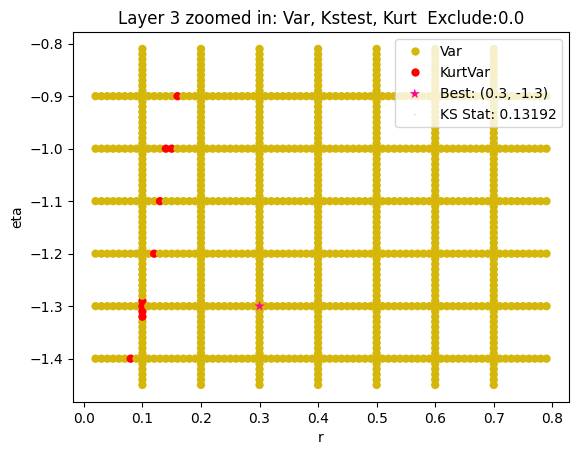

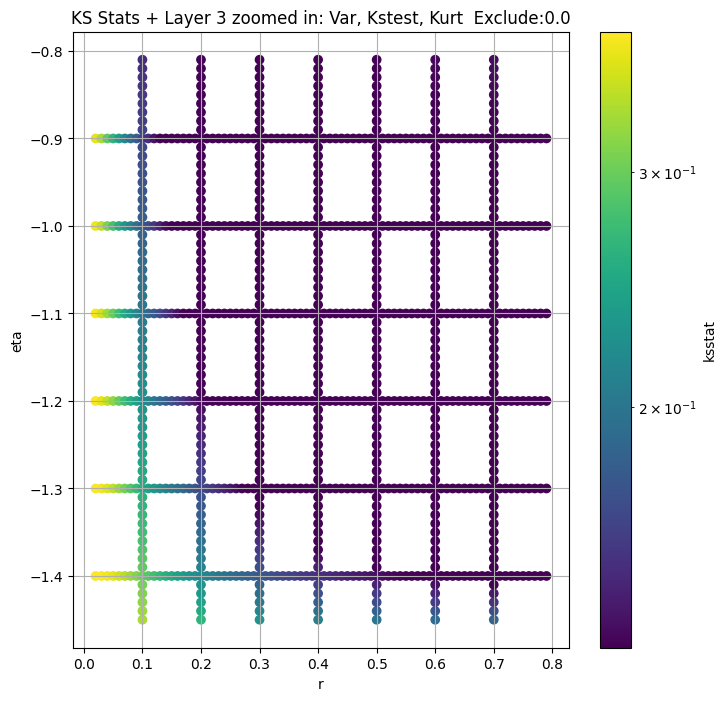

Layer 4


100%|██████████| 1190/1190 [00:03<00:00, 299.88it/s]


Finding Minimum after computing 1190 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.07504999999999978, var: 1242.280029296875


100%|██████████| 1190/1190 [00:03<00:00, 301.48it/s]


Finding Minimum after computing 1190 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.07504999999999978, var: 1263.2760009765625


100%|██████████| 1190/1190 [00:03<00:00, 301.81it/s]


Finding Minimum after computing 1190 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.07504999999999978, var: 1287.4942626953125


100%|██████████| 1190/1190 [00:03<00:00, 302.10it/s]


Finding Minimum after computing 1190 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.07504999999999978, var: 1318.3868408203125


100%|██████████| 1190/1190 [00:03<00:00, 300.87it/s]


Finding Minimum after computing 1190 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.07504999999999978, var: 1375.0799560546875
Number of samples: 100000, Without approximation : 333298.0


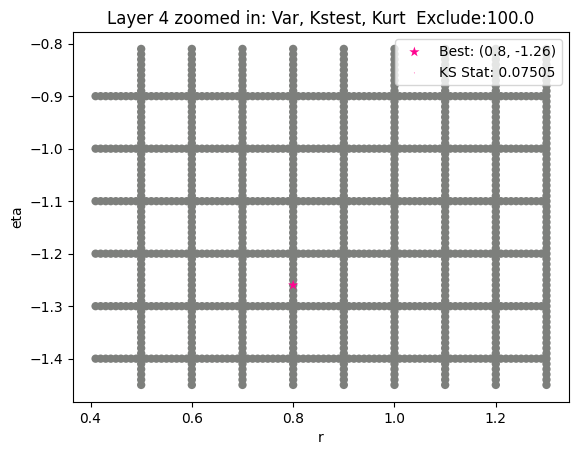

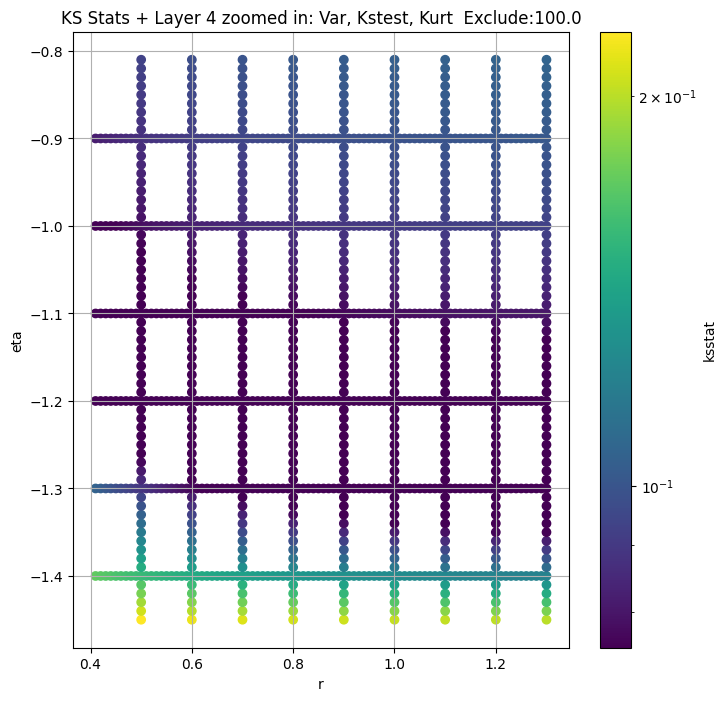

Layer 5


100%|██████████| 54/54 [00:00<00:00, 281.66it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.040510860492171896, var: 289.61737060546875


100%|██████████| 54/54 [00:00<00:00, 300.95it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.04065561817536051, var: 292.3722229003906


100%|██████████| 54/54 [00:00<00:00, 300.18it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.04053458861245052, var: 295.2117004394531


100%|██████████| 54/54 [00:00<00:00, 300.79it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.04009703707719889, var: 298.1505432128906


100%|██████████| 54/54 [00:00<00:00, 298.21it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.039754664162670095, var: 301.1906433105469


100%|██████████| 54/54 [00:00<00:00, 297.16it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.03975486772722242, var: 304.3410949707031


100%|██████████| 54/54 [00:00<00:00, 287.57it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.039755108965516595, var: 307.62091064453125


100%|██████████| 54/54 [00:00<00:00, 299.16it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.03975535665548252, var: 311.0439147949219


100%|██████████| 54/54 [00:00<00:00, 299.54it/s]


Finding Minimum after computing 54 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.03975561121957727, var: 314.6217956542969
Number of samples: 100000, Without approximation : 1149538.0


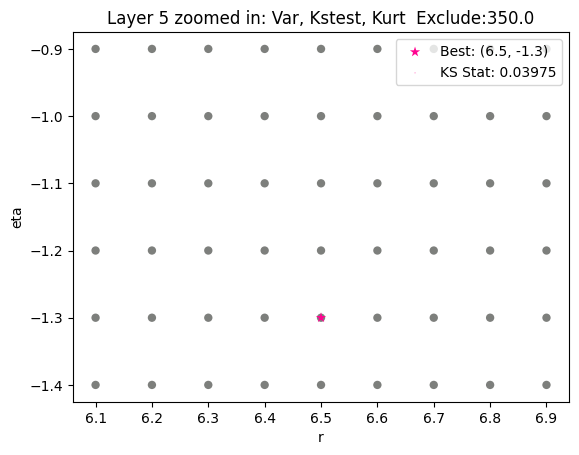

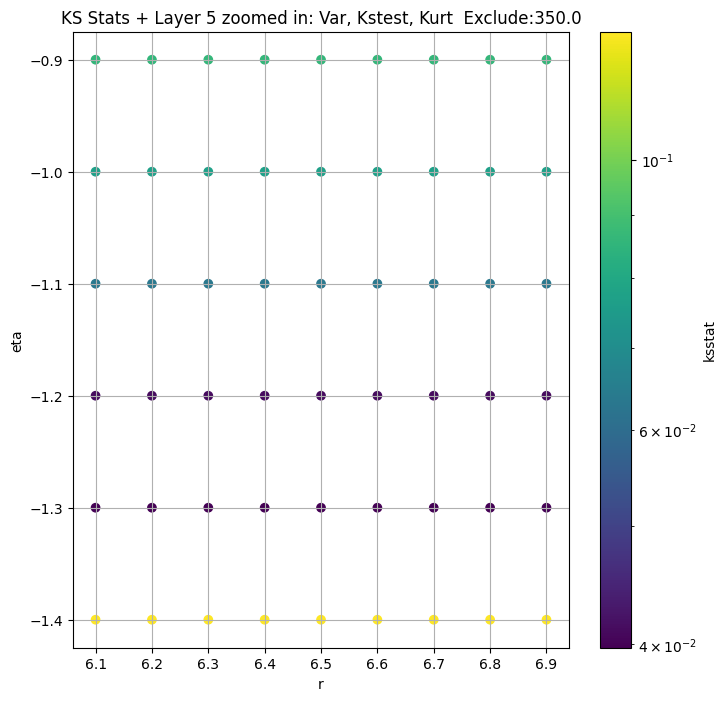

Layer 6


100%|██████████| 1305/1305 [00:04<00:00, 299.62it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.013762959130042884, var: 75.28389739990234


100%|██████████| 1305/1305 [00:04<00:00, 301.86it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.01372040826594334, var: 76.45860290527344


100%|██████████| 1305/1305 [00:04<00:00, 301.95it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.013124456626603831, var: 77.75585174560547


100%|██████████| 1305/1305 [00:04<00:00, 302.34it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.012426879232772414, var: 79.22087860107422


100%|██████████| 1305/1305 [00:04<00:00, 301.31it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.01232565470071112, var: 80.92674255371094


100%|██████████| 1305/1305 [00:04<00:00, 302.04it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.012351328419811014, var: 83.09748077392578


100%|██████████| 1305/1305 [00:04<00:00, 264.08it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.01130326705660517, var: 87.5115737915039
Number of samples: 100000, Without approximation : 4251250.0


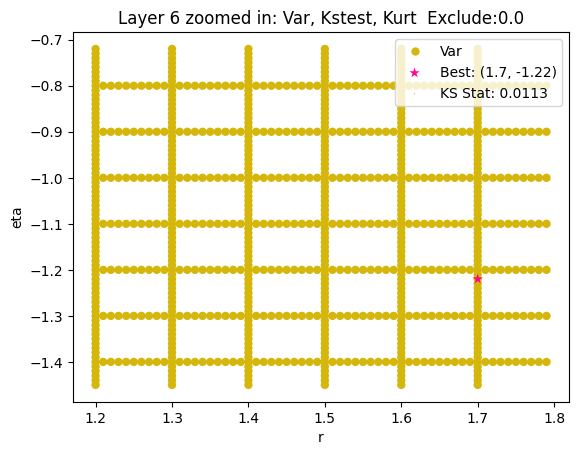

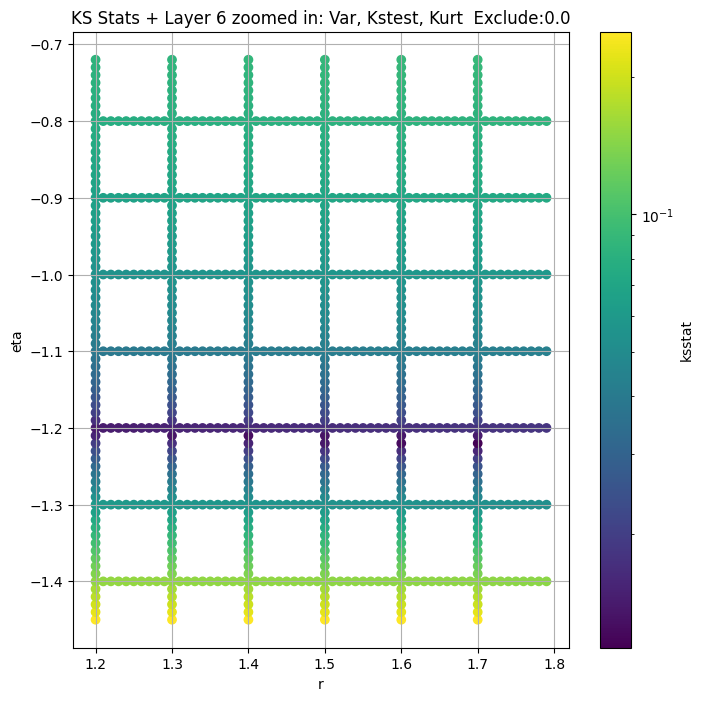

Layer 7


100%|██████████| 1305/1305 [00:04<00:00, 299.60it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 100 = 400, ksstat: 0.012719159499539612, var: 13.342637062072754


100%|██████████| 1305/1305 [00:04<00:00, 301.51it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 75 = 375, ksstat: 0.012622998577306921, var: 13.501729011535645


100%|██████████| 1305/1305 [00:04<00:00, 302.23it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 50 = 350, ksstat: 0.012594642737330908, var: 13.667123794555664


100%|██████████| 1305/1305 [00:04<00:00, 302.16it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 25 = 325, ksstat: 0.012935217628149642, var: 13.83945369720459


100%|██████████| 1305/1305 [00:04<00:00, 301.86it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 0 = 300, ksstat: 0.012869224428352422, var: 14.019438743591309


100%|██████████| 1305/1305 [00:04<00:00, 301.58it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + -25 = 275, ksstat: 0.01276022403043503, var: 14.208182334899902


100%|██████████| 1305/1305 [00:04<00:00, 302.73it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + -50 = 250, ksstat: 0.012647436160254766, var: 14.406708717346191


100%|██████████| 1305/1305 [00:04<00:00, 300.34it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + -75 = 225, ksstat: 0.01267747678949116, var: 14.616374015808105


100%|██████████| 1305/1305 [00:04<00:00, 301.44it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + -100 = 200, ksstat: 0.013087374545370234, var: 14.839081764221191
Number of samples: 100000, Without approximation : 17005000.0


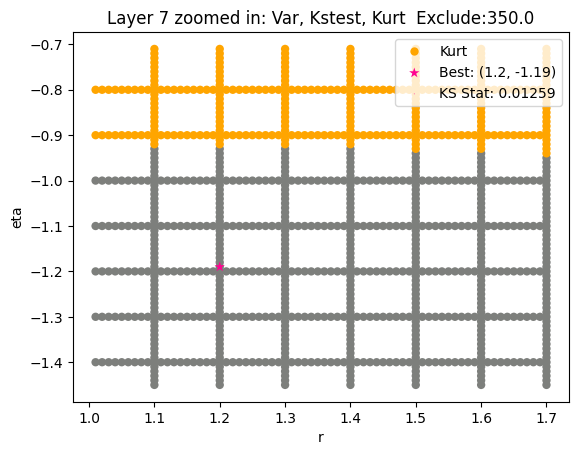

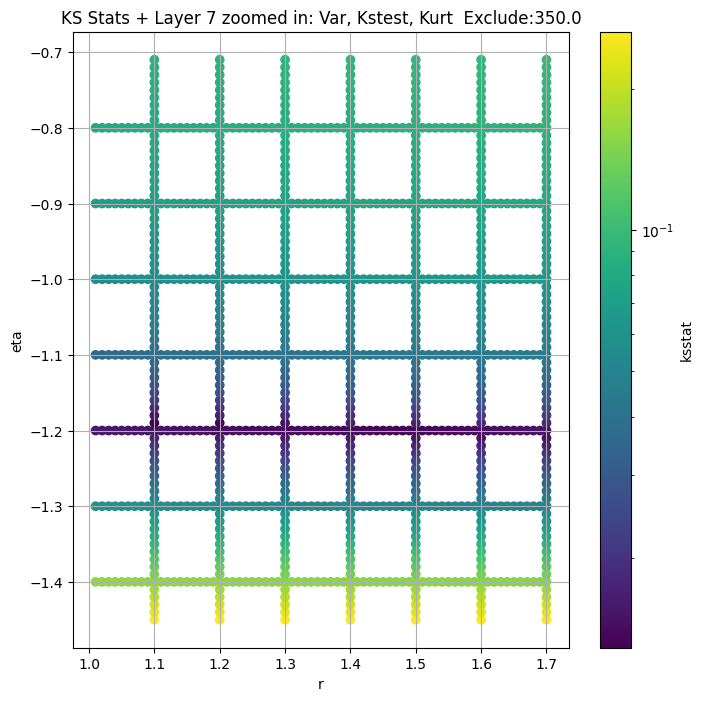

Layer 8


100%|██████████| 1480/1480 [00:04<00:00, 299.94it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 100 = 175, ksstat: 0.011953438206803058, var: 2.9759702682495117


100%|██████████| 1480/1480 [00:04<00:00, 299.50it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 75 = 150, ksstat: 0.011954236458822542, var: 3.0374746322631836


100%|██████████| 1480/1480 [00:04<00:00, 302.26it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 50 = 125, ksstat: 0.011953356916964974, var: 3.10513973236084


100%|██████████| 1480/1480 [00:04<00:00, 302.01it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 25 = 100, ksstat: 0.012173730104489244, var: 3.1807608604431152


100%|██████████| 1480/1480 [00:04<00:00, 302.23it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + 0 = 75, ksstat: 0.011954078064527085, var: 3.267357349395752


100%|██████████| 1480/1480 [00:04<00:00, 302.27it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + -25 = 50, ksstat: 0.011955304777626186, var: 3.3707103729248047


100%|██████████| 1480/1480 [00:04<00:00, 302.82it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + -50 = 25, ksstat: 0.011954930753597881, var: 3.5044965744018555


100%|██████████| 1480/1480 [00:04<00:00, 302.33it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 75.0 + -75 = 0, ksstat: 0.011954540534051539, var: 3.8332431316375732
Number of samples: 100000, Without approximation : 68020000.0


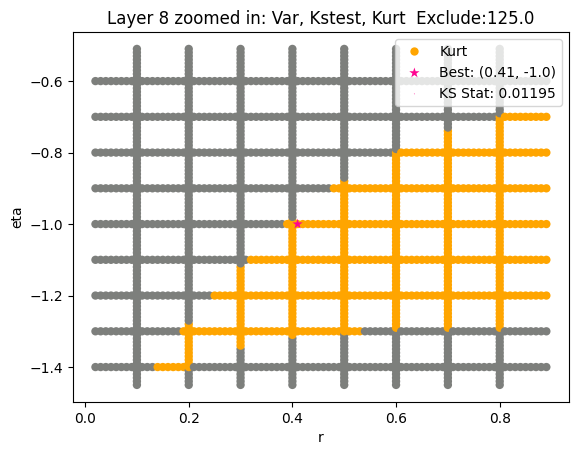

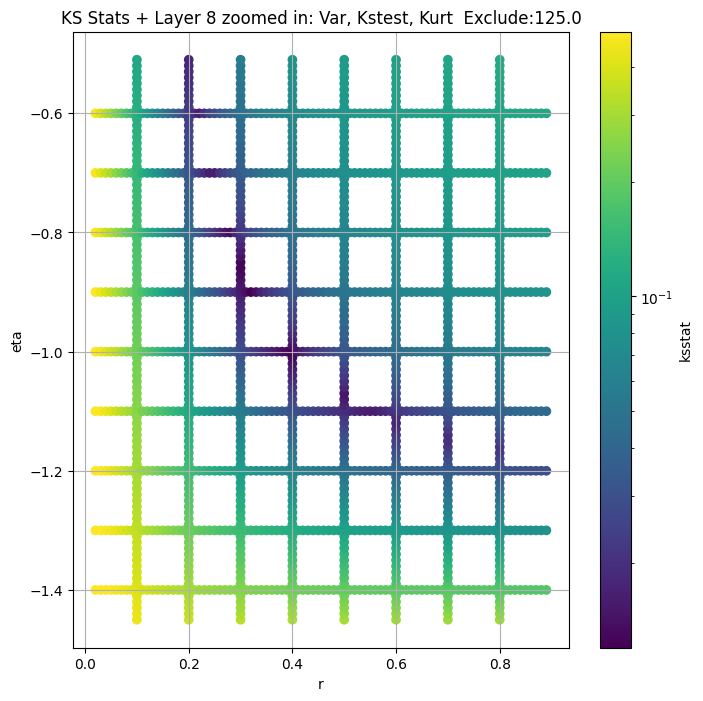

Layer 9


100%|██████████| 1665/1665 [00:05<00:00, 302.44it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 100 = 600, ksstat: 0.023454350251817635, var: 0.4008316695690155


100%|██████████| 1665/1665 [00:05<00:00, 302.71it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 75 = 575, ksstat: 0.023454383662930955, var: 0.4056148827075958


100%|██████████| 1665/1665 [00:05<00:00, 302.33it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 50 = 550, ksstat: 0.0234544175403002, var: 0.4105527997016907


100%|██████████| 1665/1665 [00:05<00:00, 302.48it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 25 = 525, ksstat: 0.023454269103089342, var: 0.41566526889801025


100%|██████████| 1665/1665 [00:05<00:00, 297.80it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + 0 = 500, ksstat: 0.023454305246808804, var: 0.42095834016799927


100%|██████████| 1665/1665 [00:05<00:00, 302.25it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + -25 = 475, ksstat: 0.023454102192625448, var: 0.4264499545097351


100%|██████████| 1665/1665 [00:05<00:00, 302.26it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + -50 = 450, ksstat: 0.02345414124762457, var: 0.43215441703796387


100%|██████████| 1665/1665 [00:05<00:00, 302.75it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + -75 = 425, ksstat: 0.023454181092599224, var: 0.43809303641319275


100%|██████████| 1665/1665 [00:05<00:00, 302.09it/s]


Finding Minimum after computing 1665 CDFs
layer 9, 500.0 + -100 = 400, ksstat: 0.023454456770959253, var: 0.44428667426109314
Number of samples: 100000, Without approximation : 272080000.0


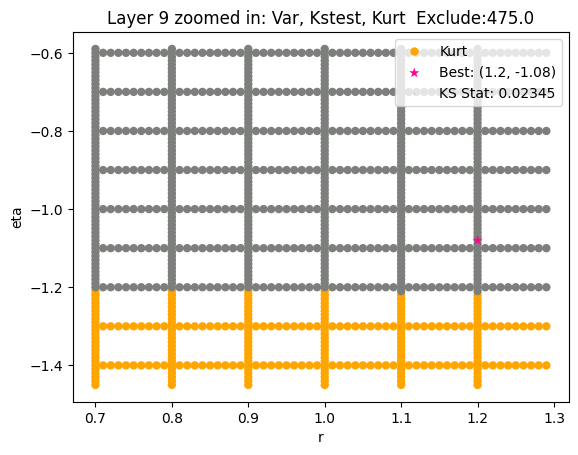

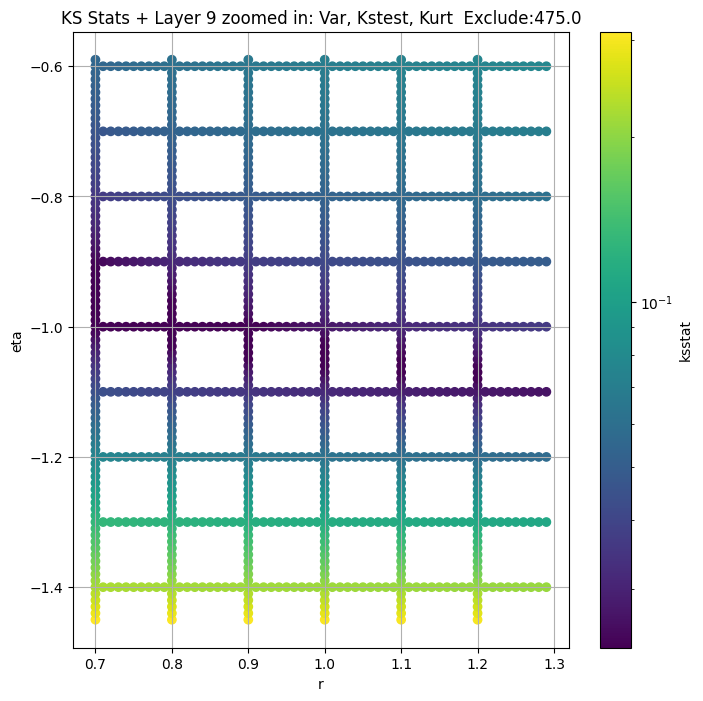

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      17099.889000  16011.852000  18265.586000    4.485044    2.916572   
3       4439.300000   4054.772500   4889.472000   11.245152    5.995430   
4       1375.080000   1259.382700   1507.248500    9.946786    6.166633   
5        383.260470    347.355300    432.730400   15.705746    6.790785   
6         87.511570     79.346710     97.936560   14.393824    7.234257   
7         18.372211     16.360151     21.660490   26.509922    9.413936   
8          3.833243      3.316128      4.835760   50.959682   13.018395   
9          0.722330      0.589106      1.182013  243.188050   15.044268   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        6.961125        27208.0             0.014667        2.5         -1.0   
3       23.181372       108832.0             0.131920        0.3         -1.3   
4       20.850872       333298.0             0.075050        0.9         -1.3   
5       61.446915      1149538.0             0.039755        6.5         -1.3   
6       41.990230      4251250.0             0.013588        1.3         -1.2   
7      122.685720     17005000.0             0.013222        1.5         -1.2   
8      233.187880     68020000.0             0.011954        0.4         -1.0   
9      913.023500    272080000.0             0.023455        0.8         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       52715.098704                     0.0        17099.889000   
3        1001.889251                     0.0         4439.300000   
4        6323.633607                     0.0         1242.280029   
5        1926.164660                   350.0          301.190640   
6         319.324128                    50.0           87.511574   
7          58.667144                   300.0           13.667124   
8           0.669579                    75.0            3.105140   
9           0.633358                   500.0            0.426450   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.008227          0.014667    2.50     -1.00   
3                     0.004115          0.131920    0.30     -1.30   
4                     0.002352          0.075050    0.80     -1.26   
5                     0.001267          0.039755    6.50     -1.30   
6                     0.000659          0.011303    1.70     -1.22   
7                     0.000329          0.012595    1.20     -1.19   
8                     0.000165          0.011953    0.41     -1.00   
9                     0.000082          0.023454    1.20     -1.08   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      52715.098704                  0.0         8607  
3       1001.889251                  0.0          106  
4       4181.008829                100.0          325  
5       1926.164660                350.0         1122  
6        403.789823                  0.0        14010  
7         50.132181                350.0        11820  
8          0.713437                125.0        12454  
9          1.176684                475.0         3501

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

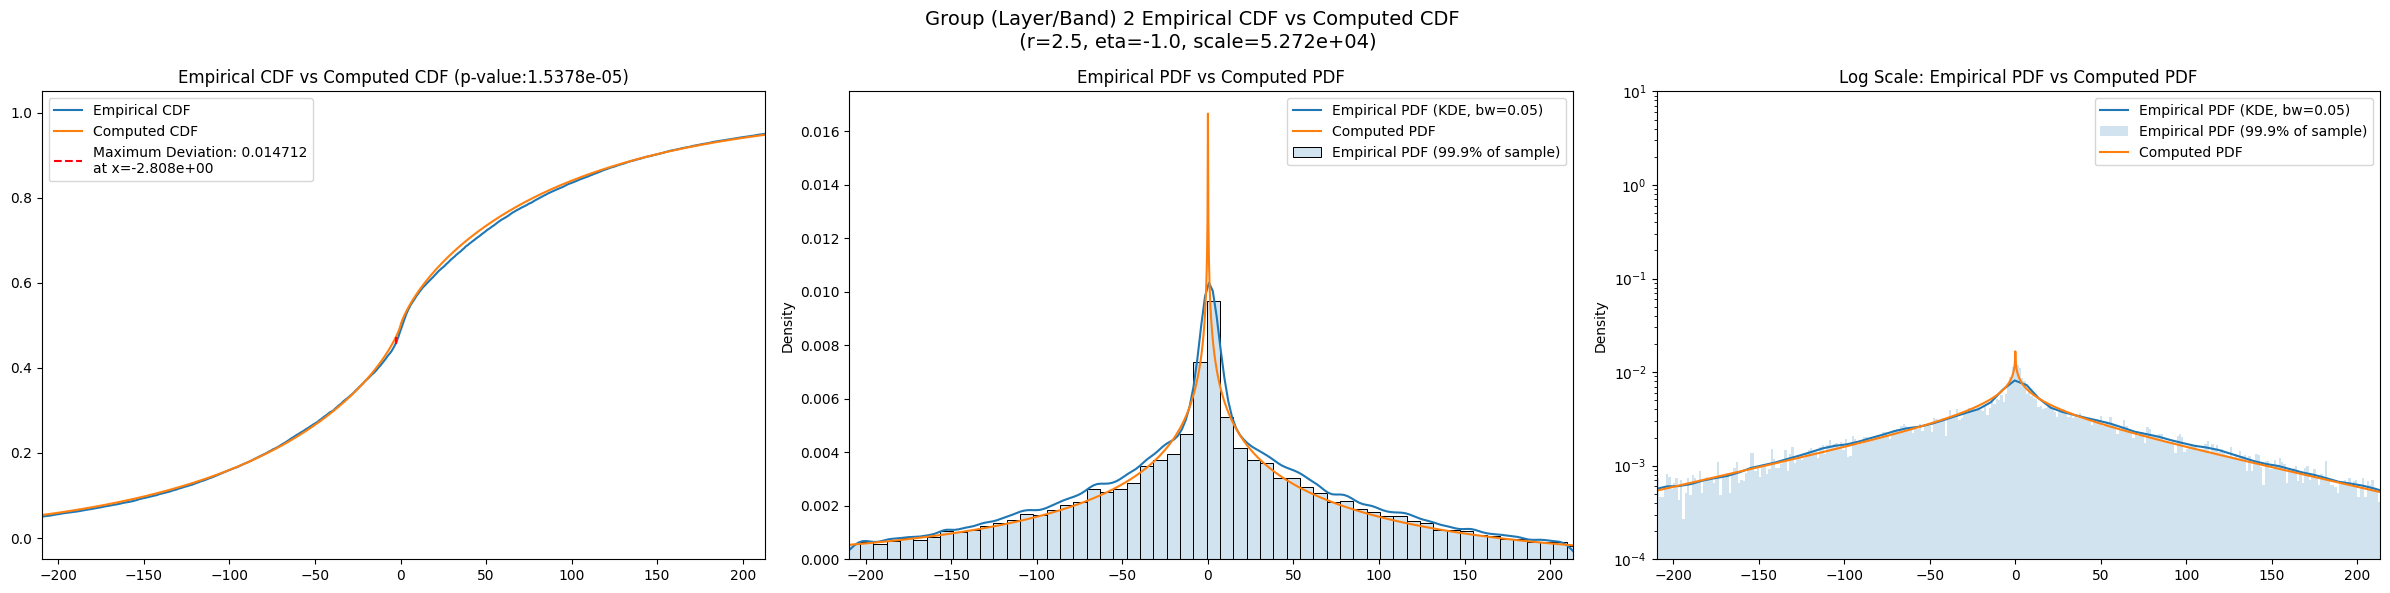

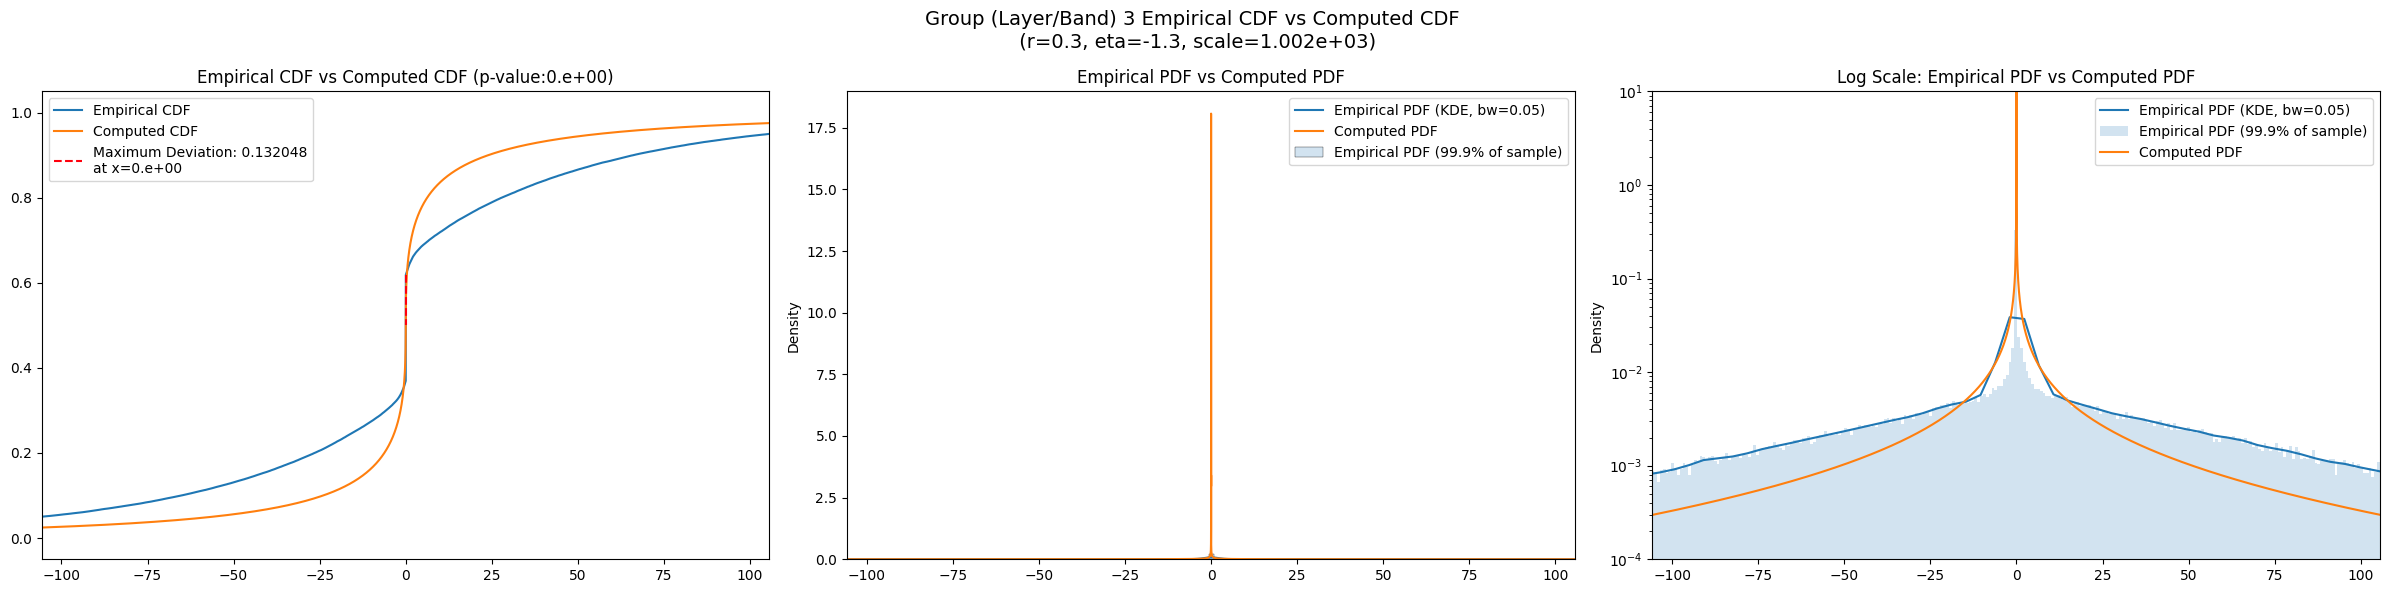

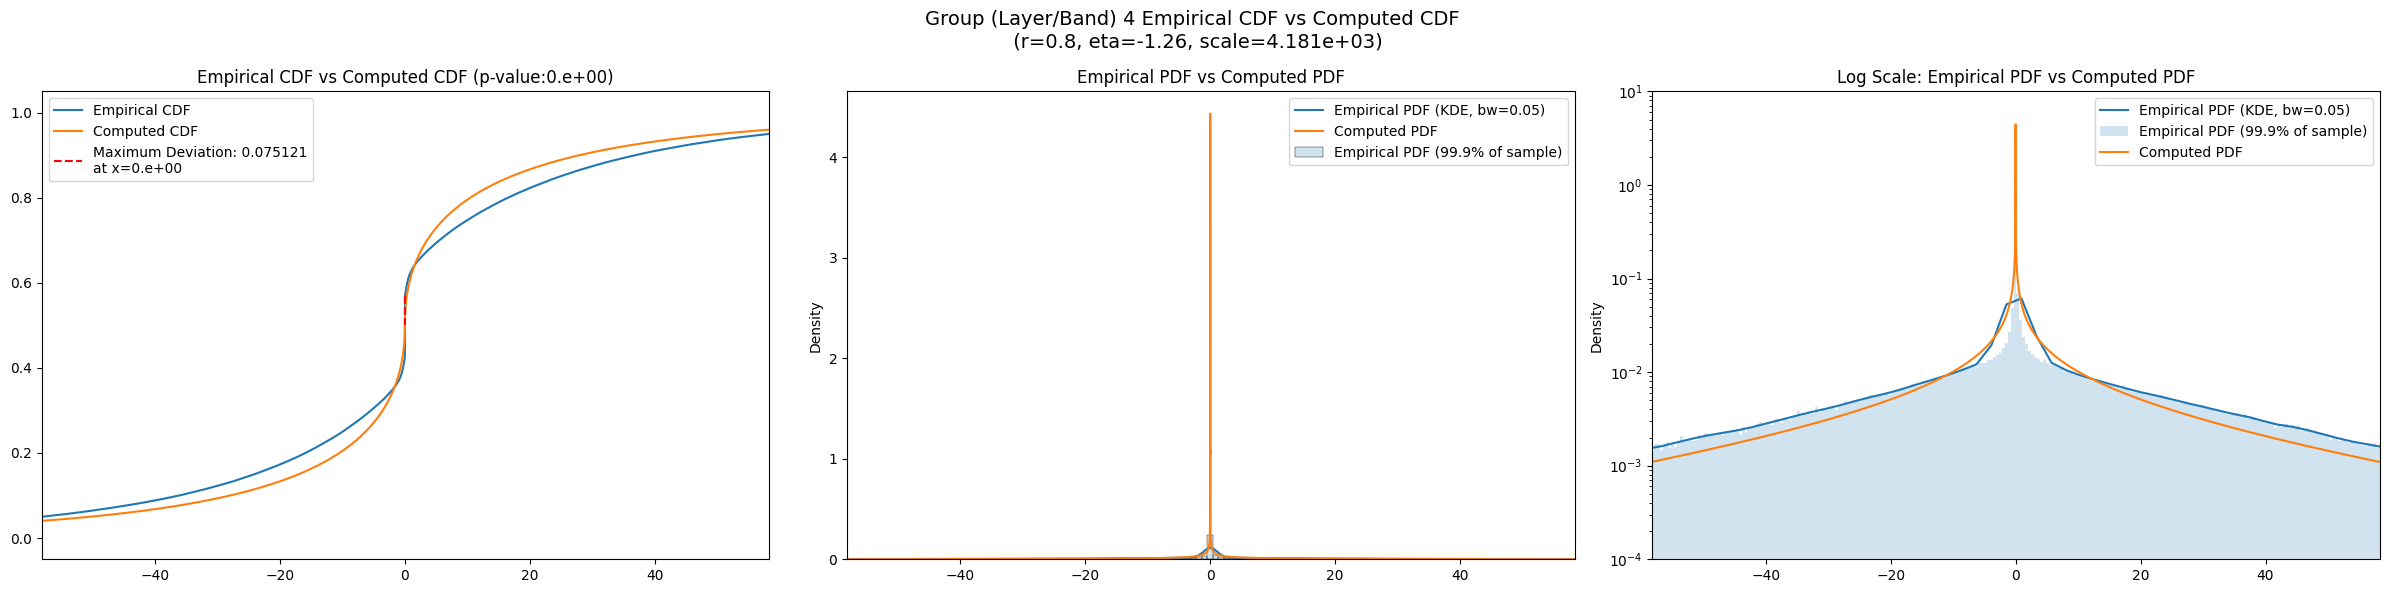

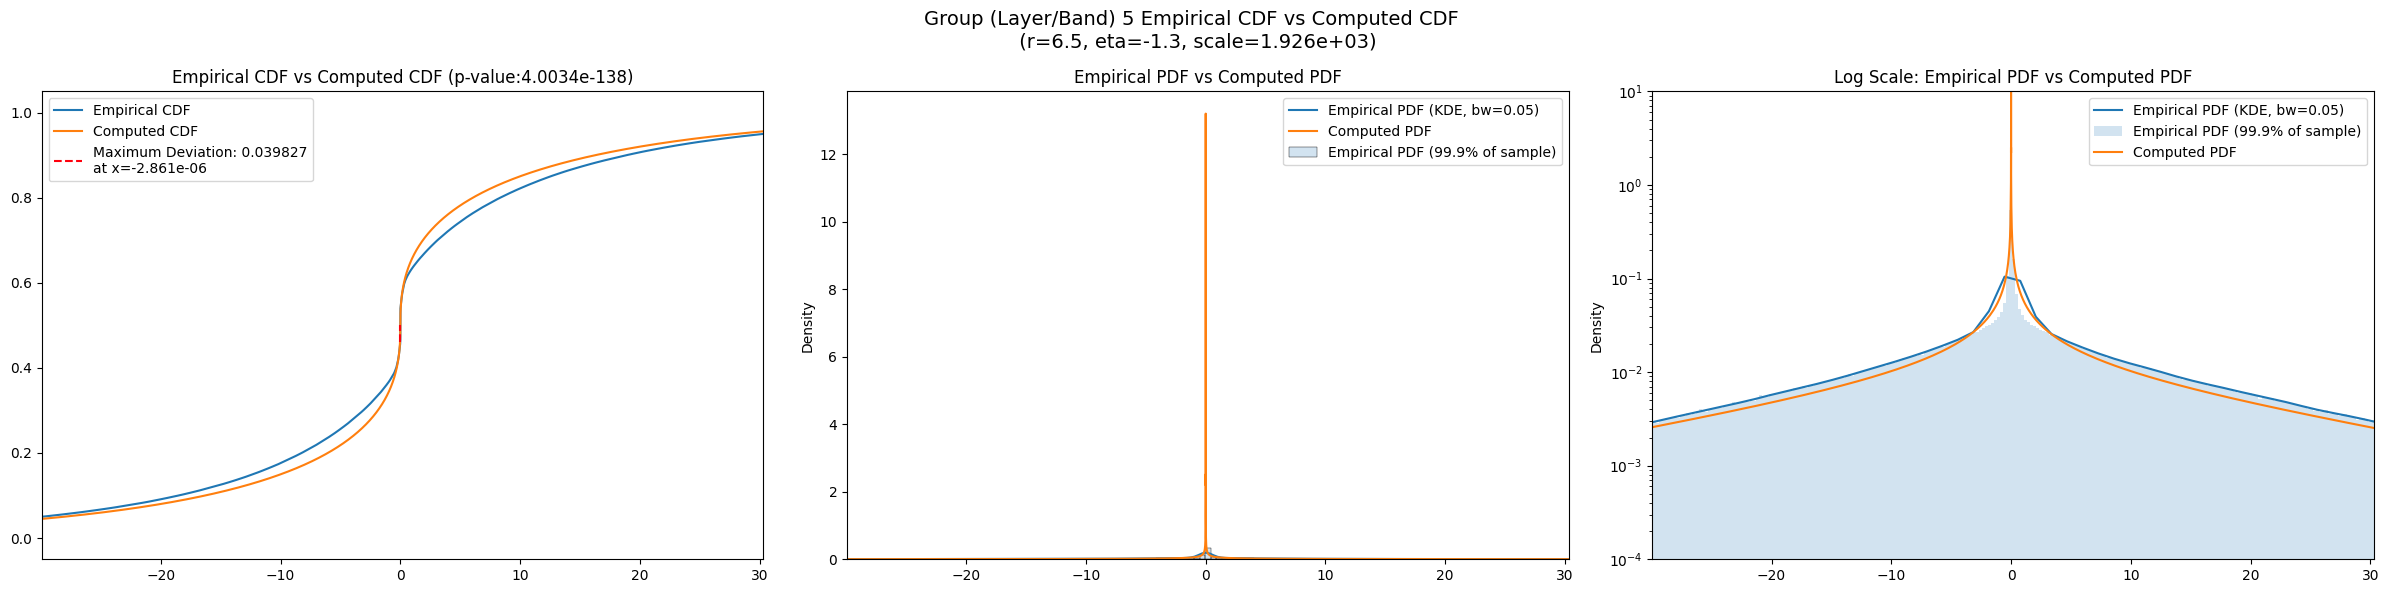

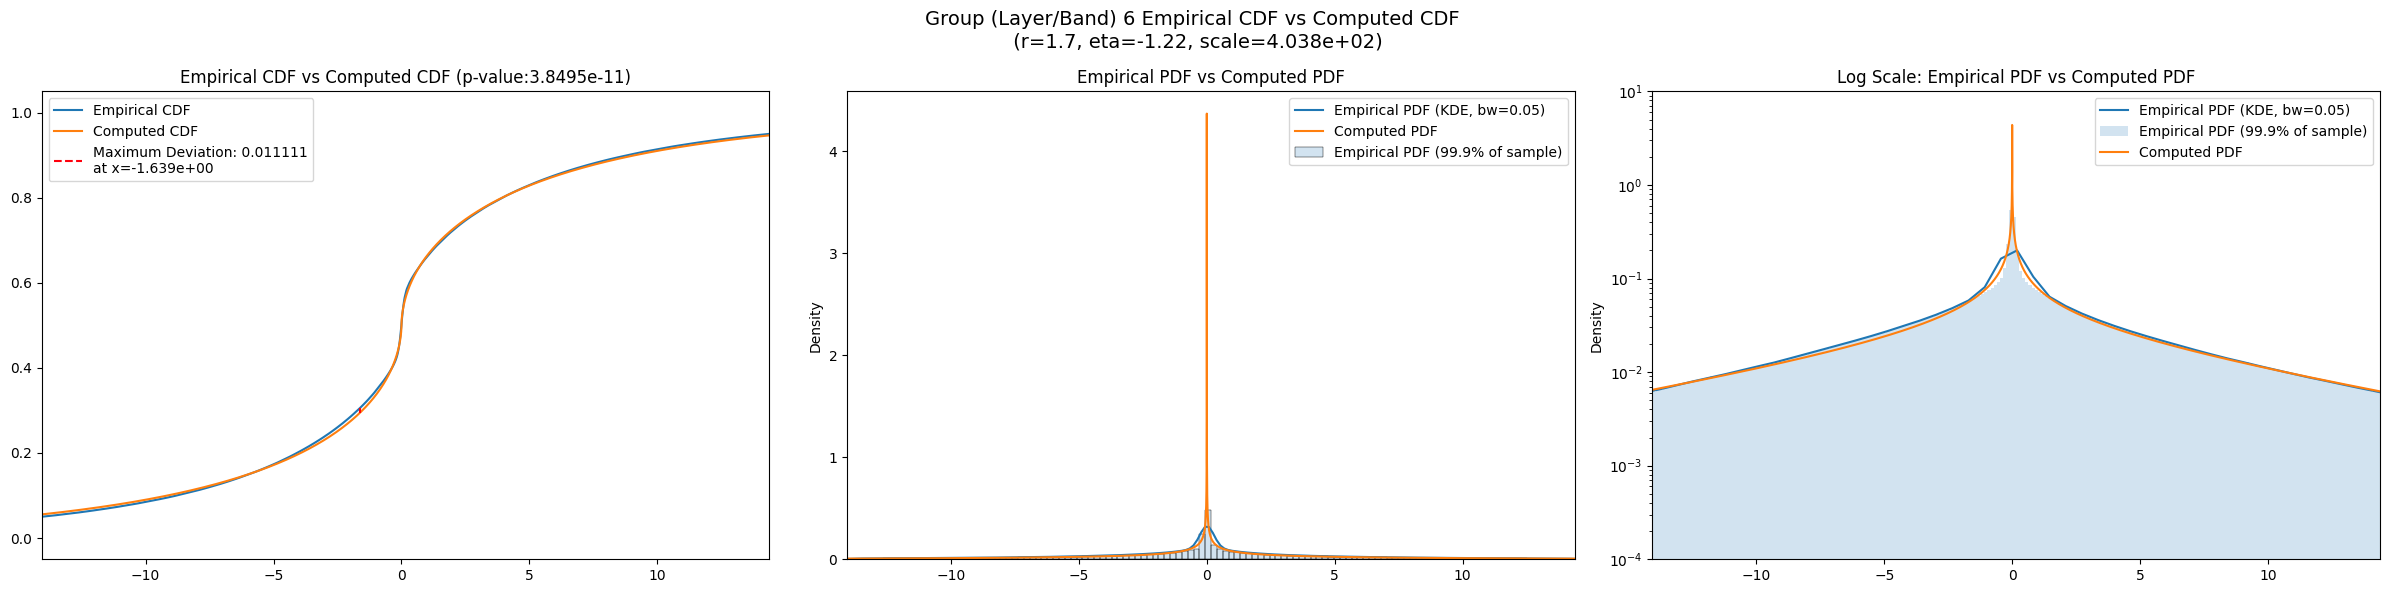

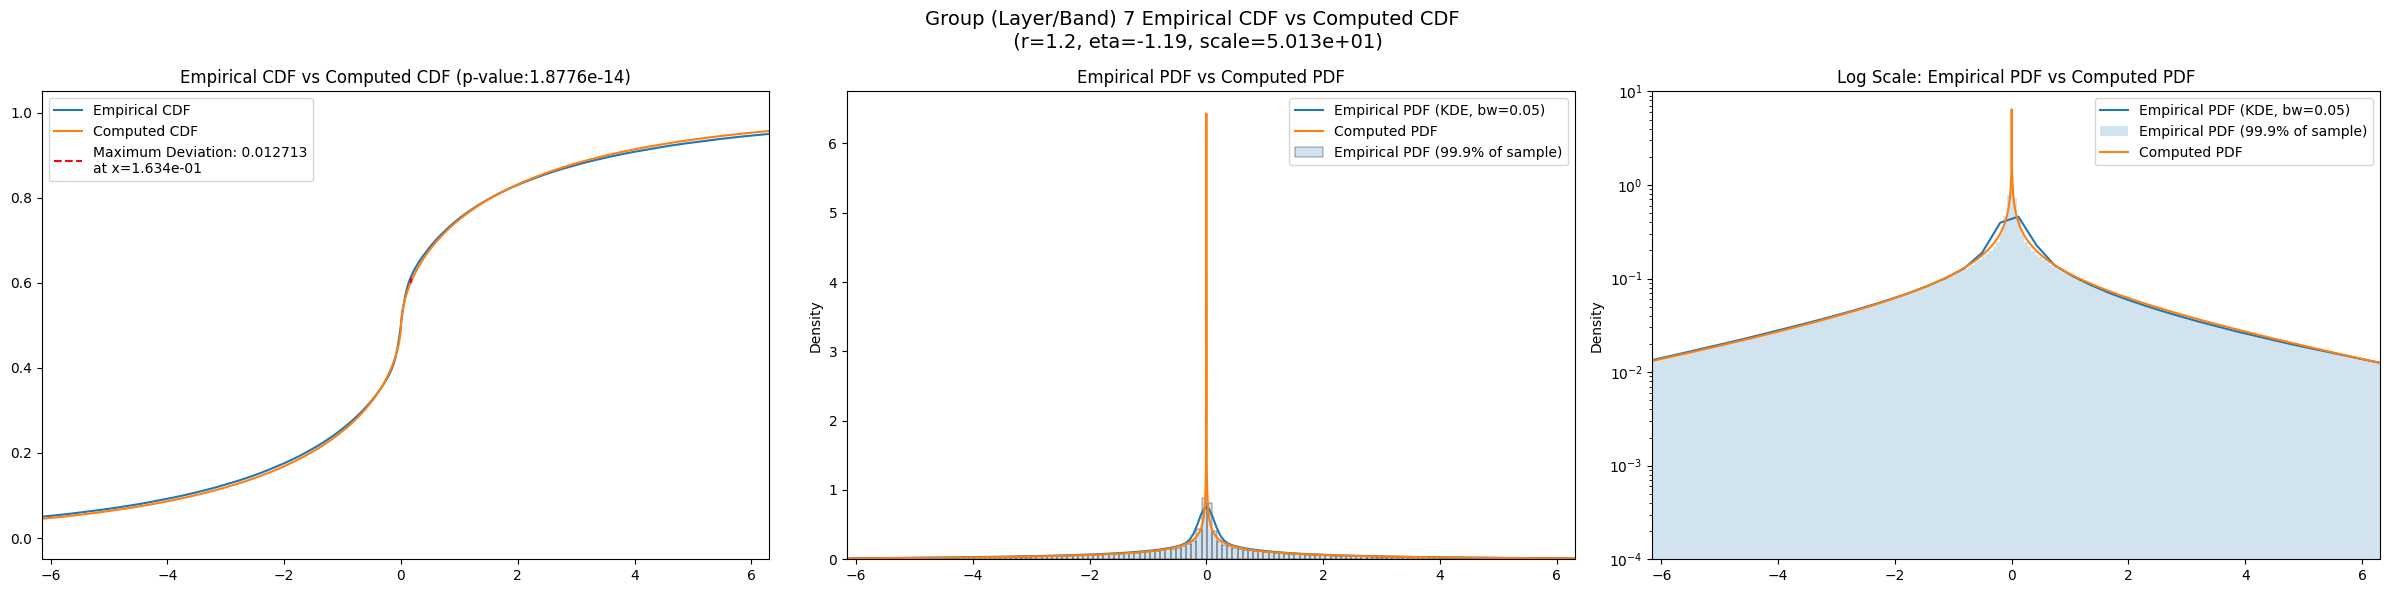

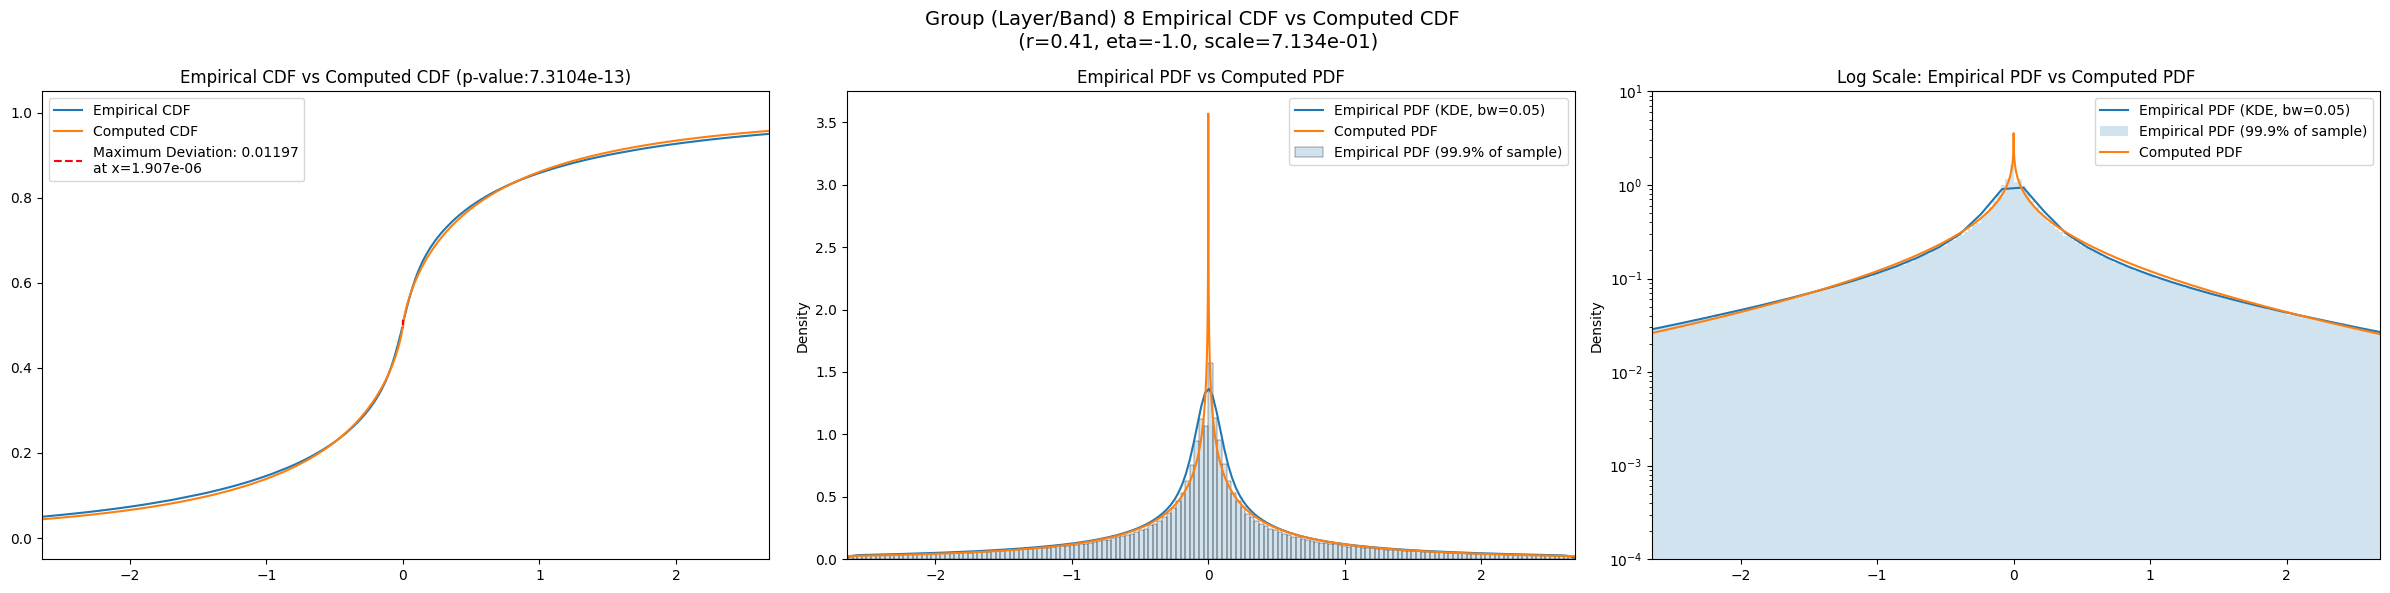

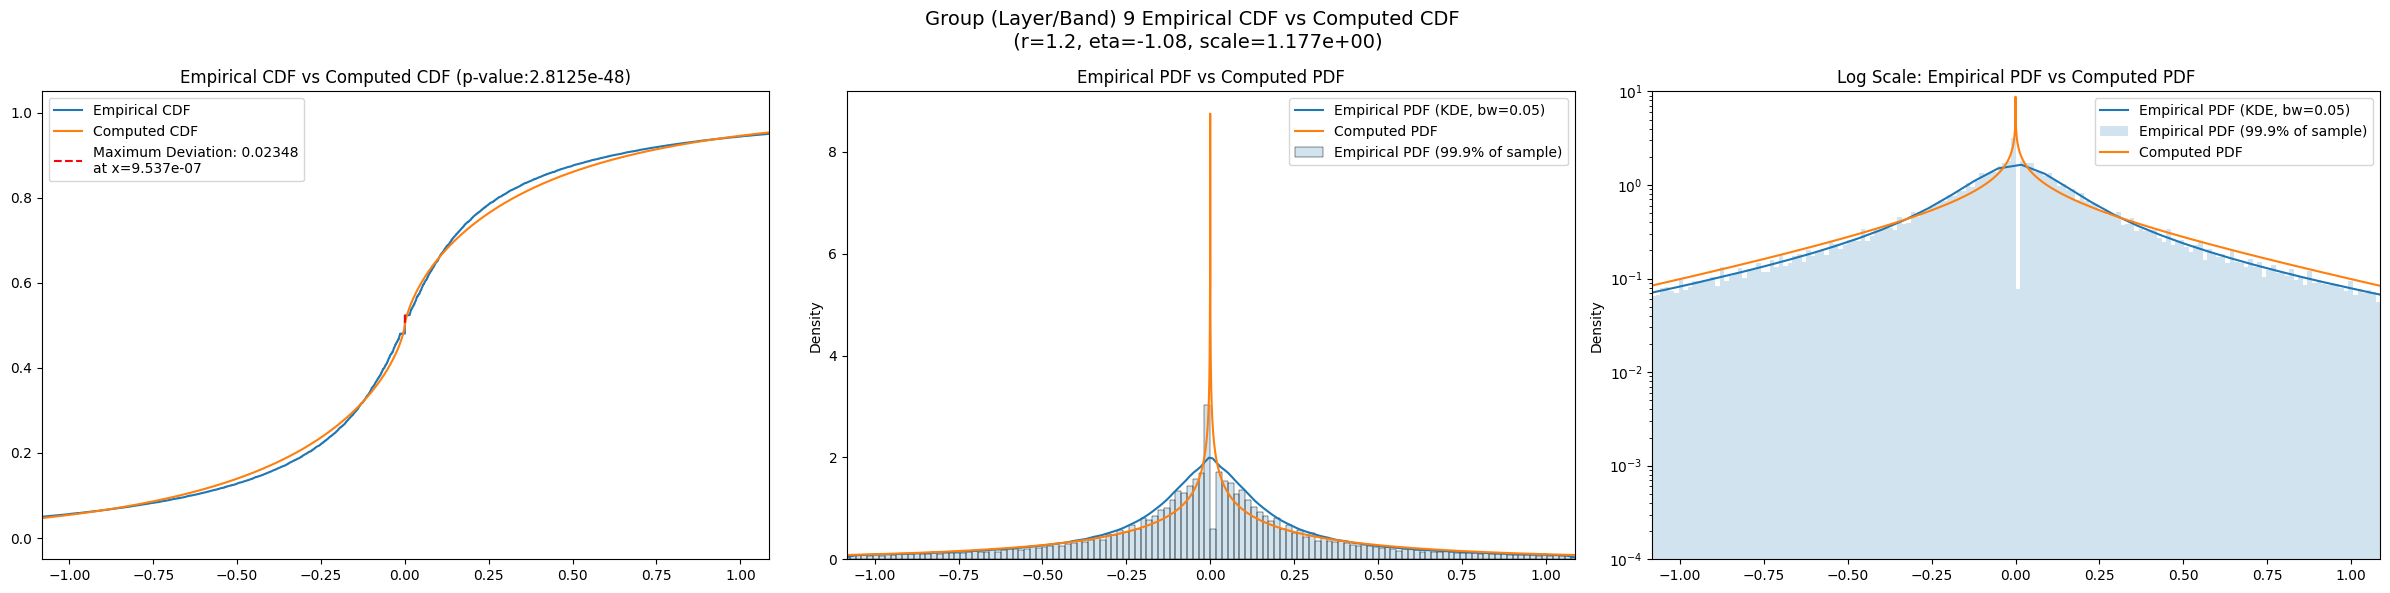

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      17099.889000  16011.852000  18265.586000    4.485044    2.916572   
3       4439.300000   4054.772500   4889.472000   11.245152    5.995430   
4       1375.080000   1259.382700   1507.248500    9.946786    6.166633   
5        383.260470    347.355300    432.730400   15.705746    6.790785   
6         87.511570     79.346710     97.936560   14.393824    7.234257   
7         18.372211     16.360151     21.660490   26.509922    9.413936   
8          3.833243      3.316128      4.835760   50.959682   13.018395   
9          0.722330      0.589106      1.182013  243.188050   15.044268   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        6.961125        27208.0             0.014667        2.5         -1.0   
3       23.181372       108832.0             0.131920        0.3         -1.3   
4       20.850872       333298.0             0.075050        0.9         -1.3   
5       61.446915      1149538.0             0.039755        6.5         -1.3   
6       41.990230      4251250.0             0.013588        1.3         -1.2   
7      122.685720     17005000.0             0.013222        1.5         -1.2   
8      233.187880     68020000.0             0.011954        0.4         -1.0   
9      913.023500    272080000.0             0.023455        0.8         -1.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       93.477400              0.045677          9.081680e-50   
3      ...       20.614500              0.134921          0.000000e+00   
4      ...       15.021000              0.104086          0.000000e+00   
5      ...        8.598790              0.089174          0.000000e+00   
6      ...        4.491680              0.075957          0.000000e+00   
7      ...        1.808860              0.081337          0.000000e+00   
8      ...        0.760140              0.078150          0.000000e+00   
9      ...        0.382416              0.058575          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          77.913900             0.028186         3.268860e-19  65.653100   
3          14.469600             0.131934         0.000000e+00  11.582400   
4          11.613900             0.091566         0.000000e+00   9.375270   
5           6.679590             0.075348         0.000000e+00   5.375860   
6           3.593070             0.058225         0.000000e+00   2.904830   
7           1.489770             0.060195         0.000000e+00   1.185750   
8           0.656986             0.051940         0.000000e+00   0.516644   
9           0.336840             0.031391         0.000000e+00   0.268257   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.032655   1.217280e-25              0.000016  
3           0.131936   0.000000e+00              0.000000  
4           0.094498   0.000000e+00              0.000000  
5           0.078321   0.000000e+00              0.000000  
6           0.061891   0.000000e+00              0.000000  
7           0.063778   0.000000e+00              0.000000  
8           0.053330   0.000000e+00              0.000000  
9           0.030290   0.000000e+00              0.000000  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.014667                 0.008227          0.014667   
3                 0.131920                 0.004115          0.131920   
4                 0.075050                 0.002352          0.075050   
5                 0.039755                 0.001267          0.039755   
6                 0.013588                 0.000659          0.011303   
7                 0.013222                 0.000329          0.012595   
8                 0.011954                 0.000165          0.011953   
9                 0.023455                 0.000082          0.023454   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.045677             0.028186       0.032655  
3                  0.134921             0.131934       0.131936  
4                  0.104086             0.091566       0.094498  
5                  0.089174             0.075348       0.078321  
6                  0.075957             0.058225       0.061891  
7                  0.081337             0.060195       0.063778  
8                  0.078150             0.051940       0.053330  
9                  0.058575             0.031391       0.030290

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            17099.889000          0.014667    2.50     -1.00  52715.098704   
3             4439.300000          0.131920    0.30     -1.30   1001.889251   
4             1242.280029          0.075050    0.80     -1.26   4181.008829   
5              301.190640          0.039755    6.50     -1.30   1926.164660   
6               87.511574          0.011303    1.70     -1.22    403.789823   
7               13.667124          0.012595    1.20     -1.19     50.132181   
8                3.105140          0.011953    0.41     -1.00      0.713437   
9                0.426450          0.023454    1.20     -1.08      1.176684   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                    100.0  
5                    350.0  
6                      0.0  
7                    350.0  
8                    125.0  
9                    475.0

In [21]:
eng.quit()